# Лабораторная работа №5. Сверточные нейронные сети

В данной лабораторной работе рассматривается решение задачи классификации посредством свёрточных нейронных сетей.
Для построения сетей предлагается использовать [Keras](https://keras.io) на базе [TensorFlow](https://www.tensorflow.org).

In [15]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import sklearn as sk
import sklearn.datasets
import sklearn.model_selection
import random

mpl.rcParams['axes.grid'] = True

print("tensorflow =", tf.__version__, "keras =", tf.version.VERSION)
if tuple(map(int, tf.__version__.split('.'))) < (2, 5, 0):
    tf.autograph.set_verbosity(0)
    import logging
    logging.getLogger("tensorflow").setLevel(logging.ERROR)

tensorflow = 2.15.0 keras = 2.15.0


## Задание №1

Загрузите датасет MNIST с помощью вызова `tf.keras.datasets.mnist.load_data()`.
Промасштабируйте обучающую и тестовую выборки, чтобы входные значения лежали в отрезке $[0; 1]$.

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.float32(x_train / 255.0).reshape(*(x_train.shape), 1)
x_test = np.float32(x_test / 255.0).reshape(*(x_test.shape), 1)

print(x_train.dtype, x_train.shape, y_train.shape)
assert x_train.dtype == np.float32 and x_test.dtype == np.float32, 'Неправильный тип входных данных'
assert x_train.shape[1:] == (28, 28, 1) and x_test.shape[1:] == (28, 28, 1), 'Неправильная размерность входных данных'
assert (x_train <= 1).all() and (x_test <= 1).all(), 'Неправильный диапазон входных данных'

float32 (60000, 28, 28, 1) (60000,)


Изучите приведённую ниже сеть с архитектурой:

1. Свёточный слой с 16 фильтрами размера $3\times3$ и функцией активации relu
1. Слой MaxPooling с размером шага 2
1. Свёточный слой с 32 фильтрами размера $3\times3$ и функцией активации relu
1. Слой MaxPooling с размером шага 2
1. Свёточный слой с 64 фильтрами размера $3\times3$ и функцией активации relu
1. Слой линеаризации
1. Полносвязный слой с количеством нейронов равным количеству выходных классов с функцией активации softmax

В качестве градиетного спуска выступает SGD, размер батча определяется при обучении модели.
Для вычисления функции потерь используется кросс-энтропия по категориям с автоматическим OneHot кодированием.
Метрика точности соответствует $accuracy(\tilde{y}, y) = \frac{1}{N} \sum_{n=0}^{N-1} 1(\tilde{y}_n = y_n)$.
При этом точное название метрики `sparse_categorical_accuracy`, которое можно сократить до `accuracy`, так как метрика выбирается согласно функции потерь.

Запустите нейросеть.
Итоговая точность должна получится около 92% или больше.

In [7]:
%%time

def create_model1(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model1(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

y_pred = model(x_test)
print('y_test', y_test[:2], 'y_pred', y_pred[:2])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          1849

**Вопросы**:

1. Сколько всего параметров у нейронной сети?
1. Сколько всего участвует в обучении векторов из обучающей выборки?
1. Какая точность достигнута?
1. В обучающей выборке в качестве классов используются числа от 0 до 9.
Что получается на выходе у нейронной сети?
Как выходные значения нейронной сети преобразовать в номер класса?

**Ответы**:

1. 54666
2. 60000
3. 0.9338
4. Вектор размерности 10. На выходе значения внутри вектора преобразуются функцией активации softmax.

## Задание №2

Попробуйте увеличить точность классификации, например, добавив после каждого свёрточного слоя нормализацию (BatchNormalization) или изменив архитектуру сети.
Объясните целесообразность произведенных изменений.

* Добавление нормализации оказалось достаточным для повышения точности.

* Нормализация перед MaxPooling:

In [10]:
%%time

def create_model2(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model2(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_6 (Bat  (None, 28, 28, 16)        64        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 batch_normalization_7 (Bat  (None, 14, 14, 32)        128 

In [11]:
for layer in model.layers: 
    print(layer.get_weights())

[]
[array([[[[ 0.05543804, -0.05274458,  0.06827907, -0.04486921,
          -0.16468649,  0.10041305, -0.11933795, -0.12414302,
           0.05858808,  0.02726529,  0.13740818, -0.09337098,
          -0.14125346, -0.12914053, -0.16363332,  0.20304827]],

        [[ 0.03242298,  0.02133761,  0.21512812,  0.16110148,
           0.14812645, -0.14271007, -0.18218528,  0.04874083,
           0.01057388, -0.10605658,  0.01127312,  0.0321144 ,
          -0.10736949, -0.06752197,  0.17896745,  0.05774788]],

        [[ 0.09851345, -0.22433257,  0.16163771,  0.15052317,
          -0.12916368, -0.10181636,  0.12543103,  0.02288857,
          -0.02463858,  0.02401629,  0.10129587, -0.04913717,
           0.17040634,  0.11551452, -0.14494331,  0.03816035]]],


       [[[-0.16622168,  0.12383373, -0.14469035, -0.06591256,
          -0.00407072,  0.14412263,  0.00079238, -0.06596382,
          -0.19898652,  0.13956545,  0.13820106, -0.1549185 ,
          -0.17187855, -0.19794075,  0.01603558, -0.145

In [12]:
for layer in model.layers: 
    print(layer.get_config())

{'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_5'}
{'name': 'conv2d_12', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
{'name': 'batch_normalization_6', 'trainable': True, 'dtype': 'float32', 'axis': ListWrapper([3]), 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config

* Нормализация после MaxPooling

In [13]:
%%time

def create_model2(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model2(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_9 (Bat  (None, 14, 14, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 7, 7, 32)          0   

**Вопросы:**

1. Почему появились необучаемые параметры (non-trainable)?
1. Распишите, какие и сколько параметров входят в BatchNormalization. Для этого воспользуйтесь переменной `layers` и методом `get_weights`.
1. Сколько параметров используется на каждом batch normalization слое?
1. Какая итоговая точность получилась? Стала ли она больше?
1. Как введение новых слоёв повлияло на вермя обучения сети?
1. Попробуйте поставить BatchNormalization слои перед/после MaxPooling. Как меняются характеристики и время обучения?

**Ответы:**

1. Слои нормализации содержат в себе необучаемые параметры.
2. beta weight, gamma weight, moving mean, moving variance.
3. (развернось предыдущего слоя) * 4.
4. Да, стала больше - 0.9843.
5. Увеличило время обучения в 2 раза в нашем случае.
6. Время обучения уменьшилось почти в 1.5 раза, но точность упала до 0.9837.

## Задание №3

Визуализируйте результат воздействия весов последней сети с первого свёрточного слоя на одно из тестовых изображений.

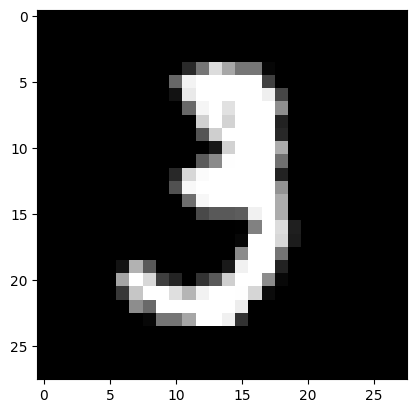

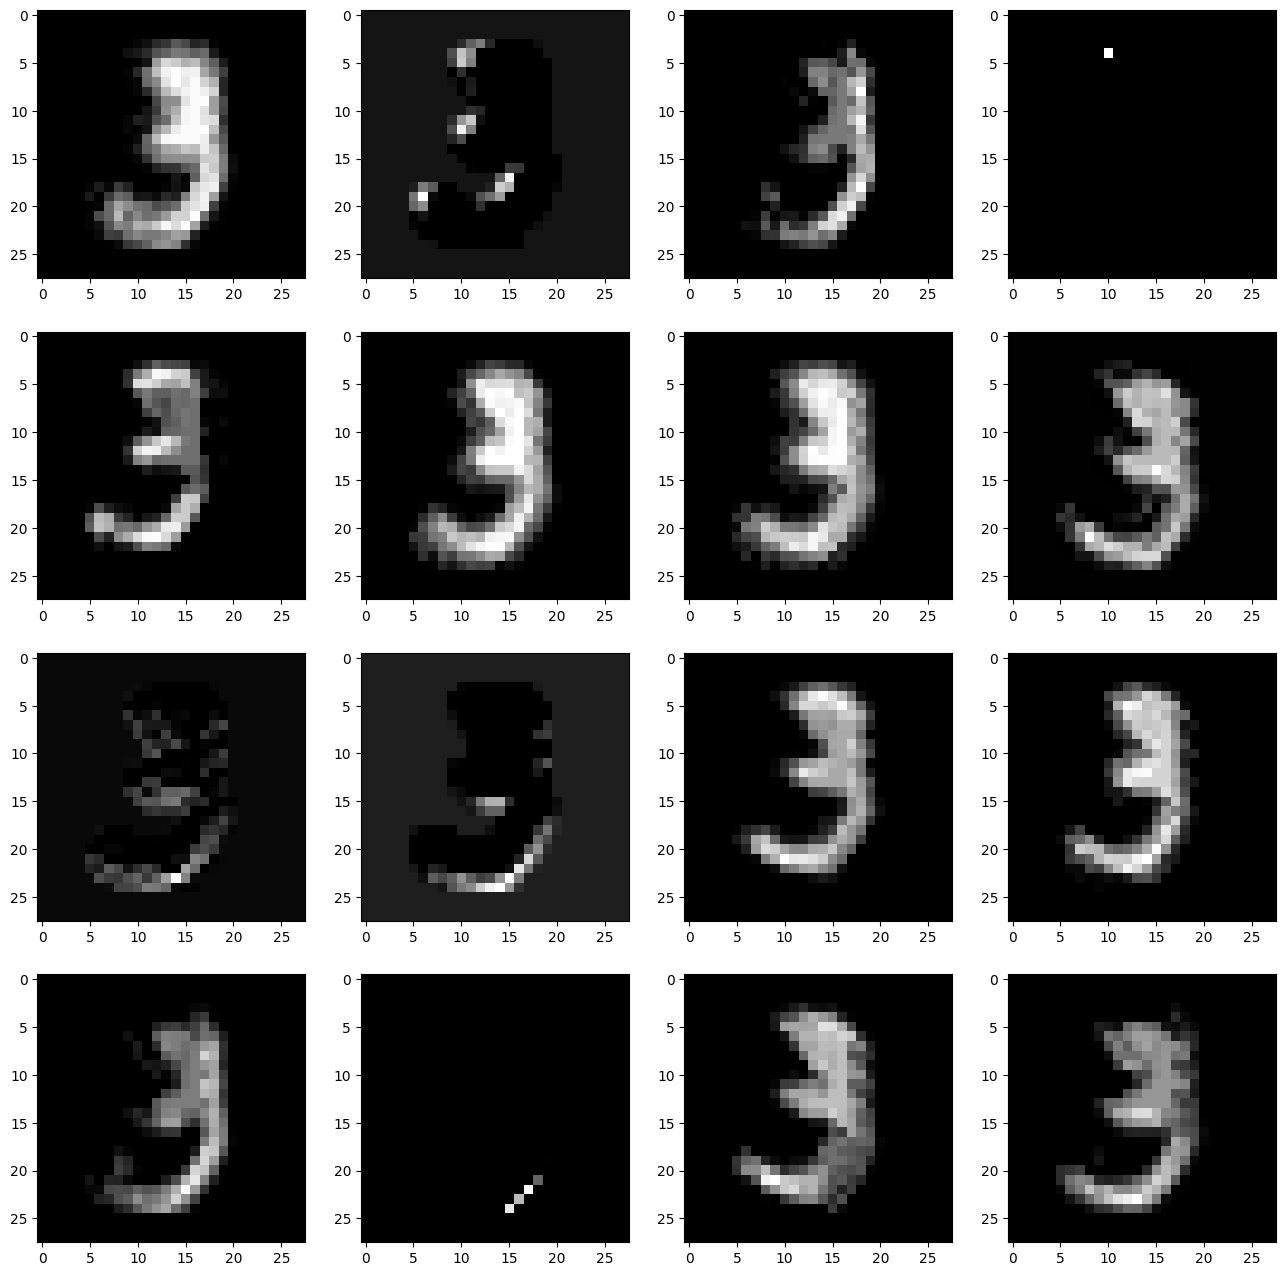

In [14]:
layer = model.get_layer(index=1)
p = layer(x_train[10:11])

plt.grid(False)
plt.imshow(x_train[10, :, :, 0], cmap='gray')

fig, axes = plt.subplots(4, 4, figsize=(4*4, 4*4))
for row, ax_rows in enumerate(axes):
    for col, ax in enumerate(ax_rows):
        ax.imshow(p[0, :, :, 4*row + col], cmap='gray')
        ax.grid(False)

**Вопросы:**

1. На что похожи отклики с первого слоя?

**Ответы:**

1. судя по тому, что некоторые из низ являются контурами, областями разположения "3" и размытыми вариациями одного изображения, похоже на воздействие различными масками.

## Задание №4

Подготовьте датасет [cifar10](https://keras.io/api/datasets/) аналогично предыдущему датасету.
Во время первого запуска будет скачиваться архив (около 170 МБ).
Он будет закеширован локально, поэтому последующие загрузки этого датасета будут занимать меньше времени.

Покажите 4 произвольных изображения из обучающей выборки.

In [17]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = np.float32(x_train / 255.0)
x_test = np.float32(x_test / 255.0)

print(x_train.shape, x_train.dtype, y_train.shape, y_train.dtype, y_test.shape)

assert x_train.dtype == np.float32 and x_test.dtype == np.float32, 'Неправильный тип входных данных'
assert (x_train <= 1).all() and (x_test <= 1).all(), 'Данные не отмасштабированы'

170498071/170498071 [==============================] - 1561s 9us/step
(50000, 32, 32, 3) float32 (50000, 1) uint8 (10000, 1)


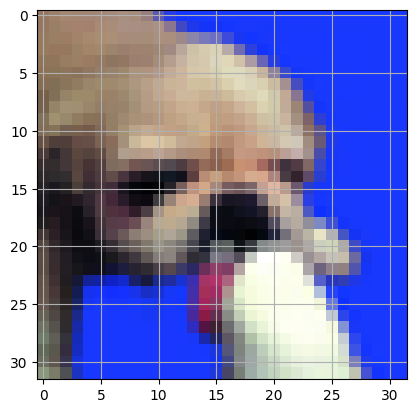

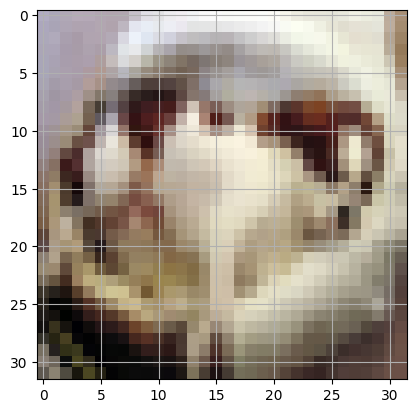

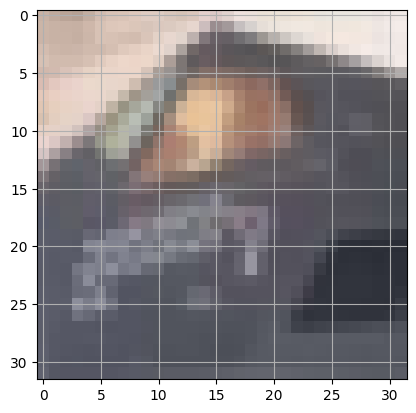

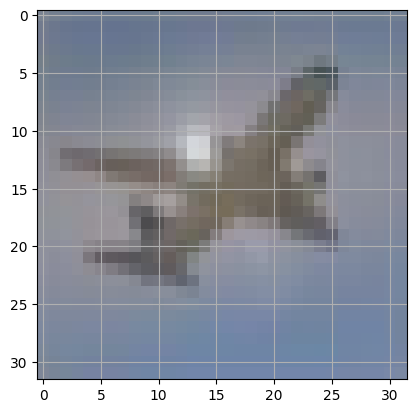

In [19]:
my_ch = random.choices(range(0, len(x_train) - 1), k = 4)
for c in my_ch:
    plt.figure()
    plt.imshow(x_train[c])

Постройте сеть с такой архитектурой:
```
convolution2dLayer: 32, 3x3, 'Padding'=1
reluLayer
maxPooling2dLayer: 2, 'Padding'=0

convolution2dLayer: 32, 3x3, 'Padding'=1
reluLayer
maxPooling2dLayer: 2, 'Padding'=0
       
convolution2dLayer: 64, 3, 'Padding'=1
reluLayer
maxPooling2dLayer: 2, 'Padding'=0

fullyConnectedLayer: 128
reluLayer 
fullyConnectedLayer: num_classes
softmaxLayer
```

Изображения цветные, поэтому для первого слоя с конволюцией укажите параметр `data_format='channels_last'`.
При обучении используйте 15 эпох, размер батча 128, оптимизатор градиентного спуска - SGD.
Также можно использовать любую другую архитектуру, объяснив целесообразность её применения.
Протестируйте работу данной сети.
Время обучения сети 5-10 минут.

In [20]:
%%time

def create_model4(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model4(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 8, 8, 64)          1849

**Вопросы:**

1. Какую точность классификации удалось получить?
1. Какие слои не имеют параметров обучения? Почему?
1. Какую размерность имеют входные изображения?

**Ответы:**

1. 0.5457
2. Входной слой (никак не преобразует изображения) и max_pooling (алгоритм взятие максимум в окне не завивисит от данных).
4. (32, 32)

## Задание №5

Попробуйте улучшить точность классификации, добавив нормализацию после свёрточных и полносвязных слоёв.

In [22]:
%%time

def create_model5(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model5(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_13 (Ba  (None, 16, 16, 32)        128 

**Вопросы:**

1. Удалось ли увеличить точность классификации введением новых слоёв?
1. Как изменилось время обучения сети? (Обратите внимание на `Wall time`, `total`, а также на время обучения каждой эпохи)

**Ответы:**

1. Да, удалось.
1. Возросло: wall time - на ~66%, total - на ~73%, для каждой эпохи  - на ~60%. 

## Задание №6

Попробуйте добавить слой dropout `tf.keras.layers.Dropout(<probability>)` после полносвязного слоя, подобрав оптимальную на Ваш взгляд вероятность удаления нейронов.
Поэкспериментируйте с добавлением слоёв BatchNormalization и без них.

* С нормализацией:

In [45]:
%%time

def create_model5(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate = 0.013)(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model5(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_87 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_42 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_88 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_43 (Ba  (None, 16, 16, 32)        128

* Без нормализации: 

In [44]:
%%time

def create_model5(input_x, input_y):
    inputs = tf.keras.layers.Input(shape=input_x.shape[1:])
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, padding='valid')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units = 128, activation='relu')(x)
    x = tf.keras.layers.Dropout(rate = 0.013)(x)
    outputs = tf.keras.layers.Dense(len(np.unique(input_y)), activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

model = create_model5(x_train, y_train)
model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_test, y_test), verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(dict(zip(model.metrics_names, score)))

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_84 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_78 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_85 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_79 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_86 (Conv2D)          (None, 8, 8, 64)          184

**Вопросы:**

1. Удалось ли увеличить точность классификации?
1. Что влияет больше на увеличение точности: слой Dropout или BatchNormalization?
1. Как изменилось время обучения?

**Ответы:**

1. Нет, точность уменьшилась.
2. Нормализация влияет больше (и в сторону увеличения).
3. Время обучения почти не изменилось (незначительно уменьшилось).